<a href="https://colab.research.google.com/github/cibic89/btc_forecast/blob/main/btc_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

T4 works great for this problem

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U autogluon
!pip install dask[dataframe]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from math import ceil
import os
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
# def find_latest_folder(path):
#     latest_folder = None

#     try:
#         # Get a list of all folders in the directory
#         folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

#         # Sort the folders alphanumerically in ascending order
#         folders.sort()

#         # Get the last folder in the sorted list
#         latest_folder = folders[-1]
#     except FileNotFoundError:
#         pass

#     return latest_folder

In [4]:
dtp = 7  # prediction length
path_to_directory = str(dtp)+"-day"
date_today = pd.to_datetime("today").strftime("%Y-%m-%d")
latest_folder = None  # find_latest_folder(path_to_directory)

result_dir = 'drive/MyDrive/code_projects/btc_forecast/results/'+path_to_directory+'/'
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print("Error: Failed to create the directory.")
# base_dir = 'drive/MyDrive/code_projects/btc_forecast/'

In [13]:
df = pd.read_csv('drive/MyDrive/code_projects/btc_forecast/Bitstamp_BTCUSD_d.csv', skiprows=1, parse_dates=["date"])
df = df.sort_values('date').drop(columns=["unix"]).reset_index(drop=True)
df = df[df["date"] < pd.Timestamp("now").normalize()]  # Drop today's data as this is most likely incomplete
df.tail(2)

,date,symbol,open,high,low,close,Volume BTC,Volume USD
3733,2025-02-16,BTC/USD,97591.0,97727.0,96066.0,96132.0,445.573811,4.283390e+07
3734,2025-02-17,BTC/USD,96066.0,97014.0,95227.0,95772.0,800.638071,7.667871e+07


In [14]:
df.dtypes, df.shape

(date          datetime64[ns]
 symbol                object
 open                 float64
 high                 float64
 low                  float64
 close                float64
 Volume BTC           float64
 Volume USD           float64
 dtype: object,
 (3735, 8))

In [15]:
ml_df = TimeSeriesDataFrame.from_data_frame(
    df,  # [df["date"]> '2022-11-08'],  # selecting data from last bull run - not a good idea (makes the model too optimistic)
    id_column="symbol",
    timestamp_column="date"
)
train_data = ml_df
# train_data, test_data = ml_df.train_test_split(prediction_length=dtp)
# print(train_data.shape, test_data.shape)

In [16]:
train_data.tail(2)

open     high      low    close  Volume BTC  \
item_id timestamp                                                    
BTC/USD 2025-02-16  97591.0  97727.0  96066.0  96132.0  445.573811   
        2025-02-17  96066.0  97014.0  95227.0  95772.0  800.638071   

                      Volume USD  
item_id timestamp                 
BTC/USD 2025-02-16  4.283390e+07  
        2025-02-17  7.667871e+07

In [17]:
# test_data.tail(2)

Validation data size: 560
Rolling-window count: 80
Val step size: 40


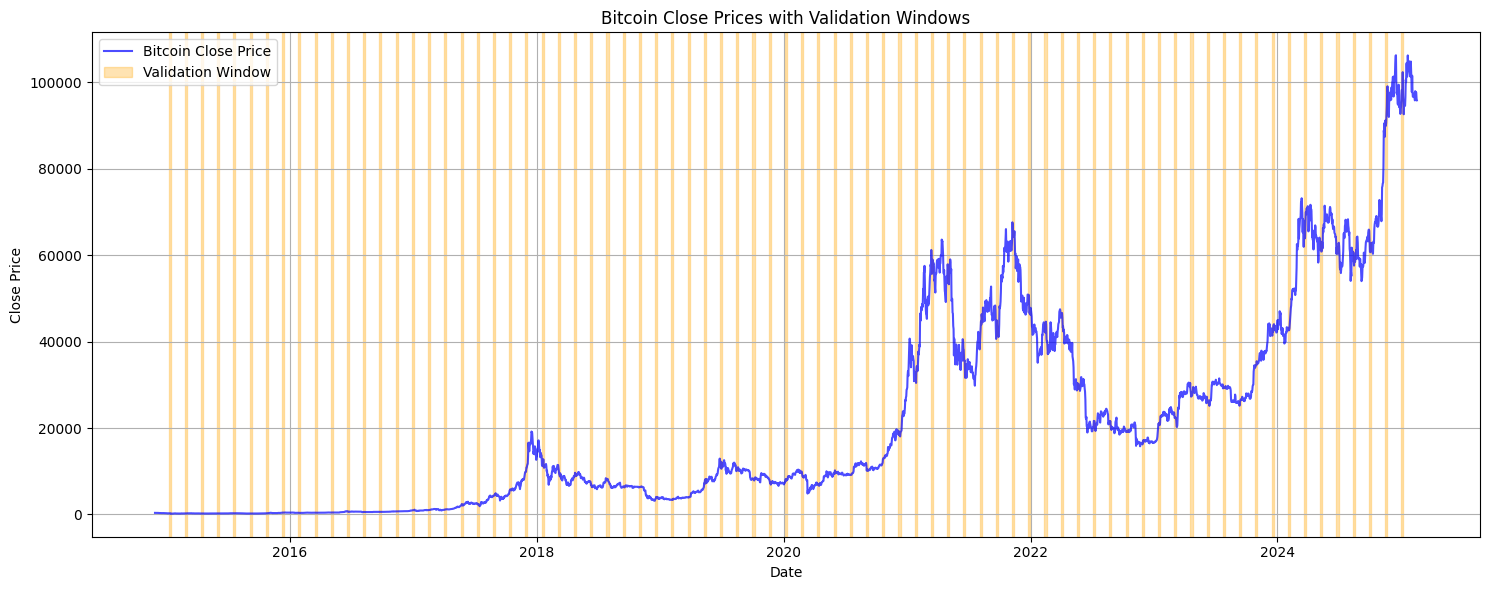

In [18]:

train_data_size = len(train_data)

val_size = int(train_data_size*0.15)  # % of validation data
print("Validation data size:", val_size)

n_windows = (val_size//dtp)
print("Rolling-window count:", n_windows)

val_step_size_n = (train_data_size - val_size) // (n_windows - 1)
print("Val step size:", val_step_size_n)

viz_df = train_data.reset_index().set_index("timestamp")

# Ensure the windows span the entire dataset, including at the end
validation_windows = []
current_iloc = 0
for i in range(n_windows):
    start_idx = current_iloc + val_step_size_n
    end_idx = start_idx + dtp
    if end_idx <= len(viz_df):  # Ensure indices are within bounds
        validation_windows.append((start_idx, end_idx))
    current_iloc = end_idx + 1

# Plot the Bitcoin close prices
plt.figure(figsize=(15, 6))
plt.plot(viz_df.index, viz_df["close"], label="Bitcoin Close Price", color="blue", alpha=0.7)

# Highlight validation windows
for start_idx, end_idx in validation_windows:
    plt.axvspan(viz_df.index[start_idx], viz_df.index[end_idx - 1],
                color="orange", alpha=0.3,
                label="Validation Window" if start_idx == validation_windows[0][0] else None)

# Add labels and legend
plt.title("Bitcoin Close Prices with Validation Windows")  # with n-fold: "+str(z))
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_val_windows.png')
except Exception as e:
    print(e)
    pass

plt.show()

In [19]:
# models = ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'NPTS', 'DynamicOptimizedTheta',
#           'AutoETS', 'ChronosZeroShot[bolt_base]', 'ChronosFineTuned[bolt_small]',
#           'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'TiDE']
# included_models = ["ChronosFineTuned[bolt_small]", "ChronosZeroShot[bolt_base]"]
# # included_models = ["SeasonalNaive"]
# excluded_model_types = [model for model in models if model not in included_models]
# excluded_model_types = ['NPTS']

In [20]:
# Get today's date
today = pd.to_datetime("today")
max_date = df["date"].max()+pd.Timedelta(days=dtp)
error_metric = "RMSE"
max_train_dur = 6*(60*60)  # seconds = hours*(min*sec)

# Check if the given date is older or equal to today's date
if (max_date >= today) and (latest_folder is not None):
    print("Using existing model")
    predictor = TimeSeriesPredictor.load(path_to_directory+os.sep+latest_folder)
else:
    print("Training a new model, this will take up to "+str(max_train_dur//60//60)+" hours")
    predictor = TimeSeriesPredictor(
        prediction_length=dtp,
        target="close",
        eval_metric=error_metric,
        path=path_to_directory  # base_dir
    )

    predictor.fit(
        train_data,
        presets="best_quality",  # 'fast_training'
        time_limit=max_train_dur,
        num_val_windows=n_windows,        # Rolling validation windows
        val_step_size=val_step_size_n,  # Controlling overlapping between validation windows, len(train_data)//n_windows means this:
        #|-------------------|
        #| x x x x x y y - - |
        #          | x x x x x x y y - |
        #                      | x x x x x x x y y |
        # val_step_size=1 (default) means this (and set num_val_windows to something very high e.g. 1/3 of dataset):
        #|-------------------|
        #| x x x x x y y - - |
        #| x x x x x x y y - |
        #| x x x x x x x y y |
        refit_full=True,
        hyperparameters={
            "PatchTST": {},
            "TiDE": {},
            "TemporalFusionTransformer": {},
            "DynamicOptimizedTheta": {},
            # "DeepAR": {},
        }
        # excluded_model_types = excluded_model_types
    )

Beginning AutoGluon training... Time limit = 14400s
AutoGluon will save models to '/content/7-day'


Training a new model, this will take up to 4 hours


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       11.38 GB / 12.67 GB (89.7%)
Disk Space Avail:   78.46 GB / 112.64 GB (69.7%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DynamicOptimizedTheta': {},
                     'PatchTST': {},
                     'TemporalFusionTransformer': {},
                     'TiDE': {}},
 'known_covariates_names': [],
 'num_val_windows': 80,
 'prediction_length': 7,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': True,
 'skip_model_selection': False,
 'target': 'close',
 'time_limit': 14400,
 'val_step_size': 40,
 'verbosity': 2}

Inferred time ser

In [21]:
# The test score is computed using the last dts of each time series in test_data
leaderboard_df = predictor.leaderboard(train_data).sort_values(["score_val"], ascending=False)  # test_data
error_val = leaderboard_df["score_val"].max()

try:
    leaderboard_df.to_csv(result_dir+date_today+'_leaderboard.csv')
except Exception as e:
    print(e)
    pass

display(leaderboard_df)
# leaderboard_df.loc[leaderboard_df[["score_test", "score_val"]].mean(axis=1).sort_values().index[-1]]

all_hyperparams = {}

# Iterate over all rows in the leaderboard
for model_name in leaderboard_df["model"]:
    # Load the model object from predictor._trainer
    model_obj = predictor._trainer.load_model(model_name)

    # Extract hyperparameters (for many models, this is stored in .params)
    hyperparams = model_obj.params

    # Store them in a dictionary keyed by model name
    all_hyperparams[model_name] = hyperparams

# Now all_hyperparams is a dict of model_name -> hyperparam dict
print(all_hyperparams)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
3,WeightedEnsemble,-994.776417,-880.266302,0.185368,0.067465,35.722713,5
7,PatchTST,-1049.040157,-928.912021,0.038180,0.013746,3410.381701,3
1,TemporalFusionTransformer,-832.181426,-966.749717,0.101273,0.033406,4480.449052,2
9,TiDE,-3001.195308,-983.820298,0.043419,0.020314,5610.354767,4
5,DynamicOptimizedTheta,-1014.383935,-1173.061421,0.426145,0.328523,98.716622,1
0,TemporalFusionTransformer_FULL,-832.181426,NaN,0.103835,NaN,58.096710,7
2,WeightedEnsemble_FULL,-994.776417,NaN,0.193241,NaN,35.722713,10
4,DynamicOptimizedTheta_FULL,-1014.383935,NaN,0.408956,NaN,0.007019,6
6,PatchTST_FULL,-1049.040157,NaN,0.034342,NaN,54.002340,8
8,TiDE_FULL,-3001.195308,NaN,0.053243,NaN,105.014844,9


{'WeightedEnsemble': {}, 'PatchTST': {}, 'TemporalFusionTransformer': {}, 'TiDE': {}, 'DynamicOptimizedTheta': {}, 'TemporalFusionTransformer_FULL': {}, 'WeightedEnsemble_FULL': {}, 'DynamicOptimizedTheta_FULL': {}, 'PatchTST_FULL': {}, 'TiDE_FULL': {}}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Usi

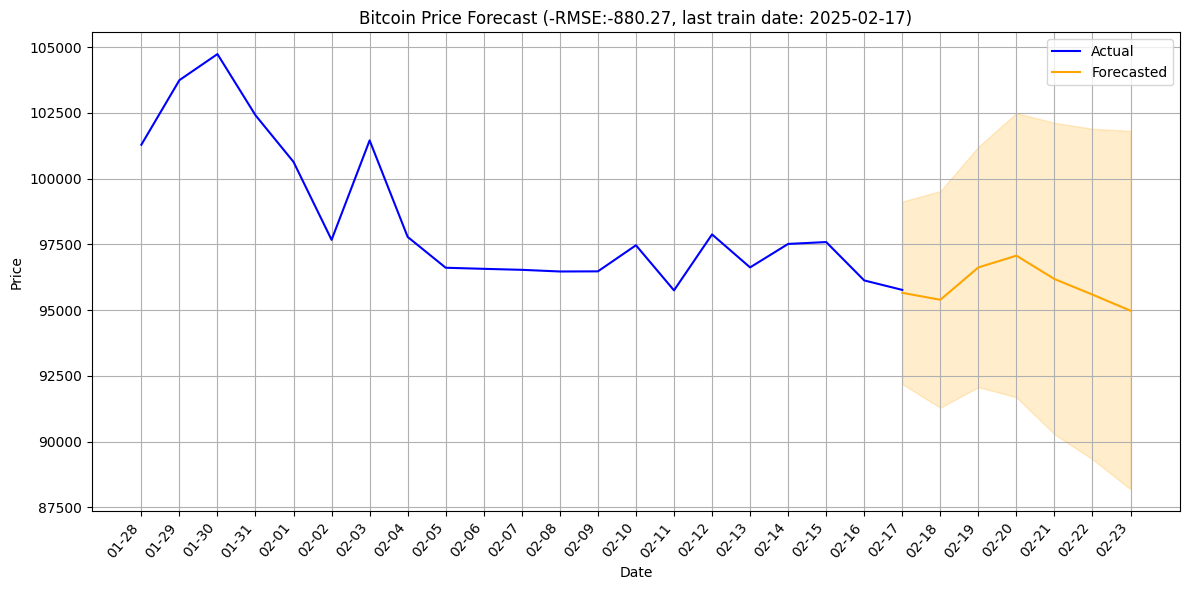

In [24]:
# Split the data points in half
viz_dp = dtp * 3

# Last train date
last_train_date = df["date"].max().strftime("%Y-%m-%d")

# Label config
x_lbl_bins = 20
x_lbl_rot = 50

# # predictions = predictor.predict(train_data)  # , model=model_to_use)
# # predictions.tail(2)

forecasts = predictor.predict(train_data.iloc[:-1])  # , model=model_to_use)
# # forecasts.head()

# # Reset the index to access 'timestamp' as a column
train_data_reset = train_data.reset_index().iloc[-viz_dp:]
# test_data_reset = test_data.reset_index().iloc[-viz_dp:]
# predictions_reset = predictions.reset_index().iloc[-viz_dp:]
forecasts_reset = forecasts.reset_index().iloc[-viz_dp:]

# Create a figure with 2 subplots (1 row, 2 columns)
# fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Format the dates to display only month and day
train_data_reset['timestamp'] = train_data_reset['timestamp'].dt.strftime('%m-%d')
# test_data_reset['timestamp'] = test_data_reset['timestamp'].dt.strftime('%m-%d')
# predictions_reset['timestamp'] = predictions_reset['timestamp'].dt.strftime('%m-%d')
forecasts_reset['timestamp'] = forecasts_reset['timestamp'].dt.strftime('%m-%d')

# Create a single figure
plt.figure(figsize=(12, 6))  # Create a single figure

# Plot actual and forecasted data together
plt.plot(train_data_reset['timestamp'], train_data_reset['close'], label='Actual', color='blue')
plt.plot(forecasts_reset['timestamp'], forecasts_reset['mean'], label='Forecasted', color='orange')
plt.fill_between(forecasts_reset['timestamp'], forecasts_reset['0.1'], forecasts_reset['0.9'], color='orange', alpha=0.2)

plt.title('Bitcoin Price Forecast (-'+error_metric+':'+str(round(error_val, 2))+', last train date: '+last_train_date+')')  # Add a clear title
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Rotate x-axis labels if needed
plt.xticks(rotation=x_lbl_rot, ha='right')

plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_forecasts.png')
except Exception as e:
    print(e)
    pass

plt.show()